# **Reinforcement Learning Project - BlackJack**


### In this project, we will try to identify the most effective game strategy for Blackjack through reinforcement learning. You will have the opportunity to investigate the fundamentals of Reinforcement Learning and explore various approaches.

## Objectives

Key aspects of this project

*   OpenAI Gym Environment Selection
*   Reinforcement Learning Concept Explanation
*   Blackjack Environment Training and Testing
*   Environment Setup
*   Learning Techniques
*   Experiment Logging
*   Comparisons and Analyses

----


## __Table of Contents__
<ol>
    <li><a href="#objectives">Objectives</a></li>
    <li><a href="#imports">Import Libraries and Setup</a></li>
    <li><a href="#Blackjack-Environment">Blackjack Environment</a></li>
    <li><a href="#Models">Models</a>
        <ol>
            <li><a href="#Random">Random</a></li>
            <li><a href="#Monte-Carlo-on-Policy-with-First-Visit-Exploring-Starts">Monte Carlo On-Policy First Visit & Exploring Starts</a></li>
            <li><a href="#Monte-Carlo-on-Policy-with-Every-Visit-Exploring-Starts">Monte Carlo On-Policy Every Visit & Exploring Starts</a></li>
            <li><a href="#Monte-Carlo-off-Policy">Monte Carlo Off-Policy</a></li>
            <li><a href="#QLearning">QLearning</a></li>
            <li><a href="#Sarsa-Temporal-Difference-control">Sarsa (Temporal Difference control)</a></li>
             <li><a href="#DeepQLearning">DeepQLearning</a></li>
        </ol>
    </li>
</ol>

## <span id="objectives">1. Objectives</span>

### Define the objectives

## 2. Import Libraries and Setup

_We recommend you import all required libraries in one place (here):_

In [2]:
# !pip install gym==0.22.0 pygame
import gym
import matplotlib.pyplot as plt
import random
import itertools
import time
import torch
from tabulate import tabulate
from collections import namedtuple, deque

import sys
sys.path.append('..') 

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from src.features.blackjackutility import game_result, average_wins, games_with_policy, reward_function, play_n_games
from src.visualization.visualize import plot_value_function, plot_policy_blackjack, training_results, create_grids, create_plots
from src.models.MonteCarlo import monte_carlo_on_policy, monte_carlo_off_policy
from src.models.QLearning import QLearningAgent
from src.models.Sarsa import SarsaAgent
from src.models.DeepQLearning import DeepQLearningAgent, ReplayMemory, set_device, select_action, optimize_model, train

## 3. Blackjack Environment

We create an openAI gym blackjack enviroment by calling gym method through the use of Make function.


In [3]:
environment = gym.make("Blackjack-v1", sab = True)

Now, it's time to explore the observation space in our environment. The observation space represents the set of all conceivable states, and we can access this space using the observation_space method

In [4]:
print(environment.observation_space)
print(environment.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


This can be described as:

States -> Tuple(Discrete(32), Discrete(11), Discrete(2)) where:
* The player's card sum can range from the lowest (1) to the highest (11, 10, 11), resulting in 32 possible states.
* The dealer's face-up card can take values between 1 and 11.
* The 'usable Ace' space can be either True or False, equating to 2 possible states.

    Hence, there are a total of 704 possible states, computed as: $32 \times 11 \times 2 = 704$. 

Actions -> [0,1]
* Either stand or hit: [0,1] i.e 0 for stand , 1 for hit


In [6]:
state = environment.reset()
print("s_{} = {}".format(0, environment.observation_space.sample())) 

s_0 = (3, 4, 1)


Let's see more possible states:


In [7]:
for i in range(15):
    print("s_{} = {}".format(i, environment.observation_space.sample()))

s_0 = (30, 6, 1)
s_1 = (1, 7, 1)
s_2 = (23, 6, 0)
s_3 = (23, 6, 0)
s_4 = (24, 10, 0)
s_5 = (6, 2, 1)
s_6 = (29, 5, 0)
s_7 = (27, 1, 0)
s_8 = (17, 4, 1)
s_9 = (14, 1, 1)
s_10 = (0, 3, 0)
s_11 = (8, 3, 1)
s_12 = (6, 6, 1)
s_13 = (11, 8, 0)
s_14 = (10, 9, 0)


In [8]:
for t in range(10):
    action=environment.action_space.sample()
    if action:
        print("Hit, A_{} = {}".format(t,action))
    else:
        print("Stay",action)

Hit, A_0 = 1
Stay 0
Hit, A_2 = 1
Stay 0
Stay 0
Stay 0
Stay 0
Stay 0
Hit, A_8 = 1
Hit, A_9 = 1


Let's also check the player and dealers cards by using `environment.player` and `environment.dealer` function 


In [7]:
print(environment.observation_space.sample())
print(environment.player)
print(environment.dealer)

(1, 8, 0)
[9, 5]
[10, 10]


We will introduce a bit more terminology, **Episode** is a set of  agent-environment interactions from initial to final state, i.e it's one game that agent the plays. In addition, our agents are operating in a discrete-time game. Each time-advancing decision is a **step** (e.x. taking some action from some state). It's easy to see that each Episode consists of a series of steps. 

Let's play through some episodes of the game, choosing random actions for each step: 


In [8]:
episodes = 2

for agent_type in ["Conservador", "Neutro", "Agressivo"]:


    for episode in range(episodes):
        total_reward = 0
        state = environment.reset()
        done = False
        print("_________________________________________")
        print("Episode {} - Agent Type: {}".format(episode, agent_type))
        print("")
        print("Initial Agent's Cards: {}".format(environment.player))
        print("Dealer's Showing Card: {}".format(environment.dealer[0]))

        while not done:
            action = environment.action_space.sample()

            print("The Agent's current sum: {}, Agent's usable ace: {}".format(state[0], state[2]))
            print("")
            if action:
                print("Action: Hit")
            else:
                print("Action: Stand")

            custom_reward = reward_function(state, action, agent_type=agent_type, player_sum=state[0])
            print("Custom Reward for Agent Type {}: {}".format(agent_type, custom_reward))

            state, default_reward, done, info = environment.step(action)

            print("The Agent has the following cards: {}".format(environment.player))

            total_reward += custom_reward  # Correção: Adiciona a custom_reward em cada jogada

        # Exibe as cartas finais do dealer após cada episódio
        print("Dealer's Final Cards: {}".format(environment.dealer))
        print("")
        print("Default Reward: {}".format(default_reward))
        print("Total Custom Reward: {}".format(total_reward))  # Custom Reward para a última jogada
        print("Total Reward for Agent Type {}: {}".format(agent_type, total_reward + default_reward))  # Correção: Adiciona custom_reward + default_reward


_________________________________________
Episode 0 - Agent Type: Conservador

Initial Agent's Cards: [4, 10]
Dealer's Showing Card: 10
The Agent's current sum: 14, Agent's usable ace: False

Action: Stand
Custom Reward for Agent Type Conservador: 0.1
The Agent has the following cards: [4, 10]
Dealer's Final Cards: [10, 5, 10]

Default Reward: 1.0
Total Custom Reward: 0.1
Total Reward for Agent Type Conservador: 1.1
_________________________________________
Episode 1 - Agent Type: Conservador

Initial Agent's Cards: [9, 2]
Dealer's Showing Card: 8
The Agent's current sum: 11, Agent's usable ace: False

Action: Hit
Custom Reward for Agent Type Conservador: -0.2
The Agent has the following cards: [9, 2, 10]
The Agent's current sum: 21, Agent's usable ace: False

Action: Stand
Custom Reward for Agent Type Conservador: 0.1
The Agent has the following cards: [9, 2, 10]
Dealer's Final Cards: [8, 5, 10]

Default Reward: 1.0
Total Custom Reward: -0.1
Total Reward for Agent Type Conservador: 0.

Run the code above a few more times and observe that our games are not really lucky. Try playing yourself, may be you can do better than a random action generator:


In [9]:
episodes = 2

for agent_type in ["Conservador", "Neutro", "Agressivo"]:


    for episode in range(episodes):
        total_reward = 0
        state = environment.reset()
        done = False
        print("_________________________________________")
        print("Episode {} - Agent Type: {}".format(episode, agent_type))
        print("")
        print("Initial Agent's Cards: {}".format(environment.player))
        print("Dealer's Showing Card: {}".format(environment.dealer[0]))

        while not done:
            action = environment.action_space.sample()
            print(state)
            print("The Agent's current sum: {}, Agent's usable ace: {}".format(state[0], state[2]))
            print("")
            if action:
                print("Action: Hit")
            else:
                print("Action: Stand")

            custom_reward = reward_function(state, action, agent_type=agent_type, player_sum=state[0])
            print("Custom Reward for Agent Type {}: {}".format(agent_type, custom_reward))

            state, default_reward, done, info = environment.step(action)

            print("The Agent has the following cards: {}".format(environment.player))

            total_reward += custom_reward  # Correção: Adiciona a custom_reward em cada jogada

        # Exibe as cartas finais do dealer após cada episódio
        print("Dealer's Final Cards: {}".format(environment.dealer))
        print("")
        print("Default Reward: {}".format(default_reward))
        print("Total Custom Reward: {}".format(total_reward))  # Custom Reward para a última jogada
        print("Total Reward for Agent Type {}: {}".format(agent_type, total_reward + default_reward))  # Correção: Adiciona custom_reward + default_reward


_________________________________________
Episode 0 - Agent Type: Conservador

Initial Agent's Cards: [2, 9]
Dealer's Showing Card: 3
(11, 3, False)
The Agent's current sum: 11, Agent's usable ace: False

Action: Stand
Custom Reward for Agent Type Conservador: 0.3
The Agent has the following cards: [2, 9]
Dealer's Final Cards: [3, 10, 10]

Default Reward: 1.0
Total Custom Reward: 0.3
Total Reward for Agent Type Conservador: 1.3
_________________________________________
Episode 1 - Agent Type: Conservador

Initial Agent's Cards: [10, 10]
Dealer's Showing Card: 5
(20, 5, False)
The Agent's current sum: 20, Agent's usable ace: False

Action: Hit
Custom Reward for Agent Type Conservador: -0.2
The Agent has the following cards: [10, 10, 4]
Dealer's Final Cards: [5, 5]

Default Reward: -1.0
Total Custom Reward: -0.2
Total Reward for Agent Type Conservador: -1.2
_________________________________________
Episode 0 - Agent Type: Neutro

Initial Agent's Cards: [8, 7]
Dealer's Showing Card: 9
(15

At first we will start by exploring what greedy policy is and does:


### Epsilon-Greedy Policy

If you remember, as was mentioned before, policy is just a function that defines which action our agent should take based on the current state. In our environment, a simple deterministic policy $\pi$ for the the state $(15,10,0)$ may look like: 

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0EP1EN/Screenshot%202022-11-23%20at%2010.36.45%20AM.png" width="50%" alt="iris image">


You may ask why wouldn't we always use the best action, the action with the best estimated reward, what's the point of this epsilon constant. For it we will have to learn about 2 more concepts: 
 
* **Exploration** happens when the agent takes the random action to explore more opportunities, gather more information about possible actions and the environment.
* **Exploitation** happens when the agent makes the best decision given current information, it uses the best estimated action to maximize the reward. 

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0EP1EN/Screenshot%202022-11-23%20at%2010.51.11%20AM.png" width="50%" alt="iris image">

As demonstrated in the diagram above, **Epsilon** defines the trade-off between Exploration and Exploitation.  We need it because the best long-term strategy may involve short-term sacrifices and in most cases, agents must explore the environment and gather enough information to make the best overall decisions. It may save our agent from doing decisions that work instead of finding the best actions. 

Let's define a new python function that will follow the epsilon probability and return an action:


## 4. Models

### 4.1 Random

In [10]:
def random_action(action_space):
    return action_space.sample()

random_policy = random_action(environment.action_space)

average, std_win = average_wins(environment, episodes=200000)
print("Average wins:", average, std_win)

Average wins: 0.2818 0.001005954173906545


### 4.2 Monte Carlo Method

#### 4.2.1 Monte Carlo On-Policy First Visit & Eploring Starts


In [5]:
import itertools
import time

# Define the hyperparameter values to test
n_episode_values = [200000]
discount_factor_values = [0.9] #, 0.70.95, 0.99, 1.0]
first_visit_values = [True]
epsilon_values = [0.05] #, 0.1, 0.2, 0.5, 0.9]
theta_values = [0]#, 0.001, 0.05, 0.1, 0.5, 1.0]

# Lists to store the results
tuning_results = []

# Perform grid search
for n_episode, discount_factor, first_visit, epsilon, theta in itertools.product(n_episode_values, discount_factor_values, first_visit_values, epsilon_values, theta_values):
    print(f"n_episode: {n_episode}, discount_factor: {discount_factor}, first_visit: {first_visit}, epsilon: {epsilon}, theta: {theta}")
    
    start_time = time.time()  # Record the start time

    policy, V, Q, DELTA = monte_carlo_on_policy(environment=environment, 
                                         N_episodes=n_episode, 
                                         discount_factor=discount_factor, 
                                         first_visit=first_visit, 
                                         epsilon=epsilon,
                                         theta=theta)
    
    elapsed_time = time.time() - start_time  # Calculate elapsed time


    average, std_win = average_wins(environment=environment, policy=policy, episodes=5000000)
    
    print(f"Average: {average}\n")
    print(f"Elapsed Time: {elapsed_time} seconds\n")  # Print the elapsed time
    
    tuning_results.append({
        "n_episode": n_episode,
        "discount_factor": discount_factor,
        "first_visit": first_visit,
        "epsilon": epsilon,
        "theta": theta,
        "average": average,
        "elapsed_time": elapsed_time
    })

# Find the best combination of hyperparameters
best_result = max(tuning_results, key=lambda x: x["average"])
print("Best Hyperparameters:")
print("n_episode:", best_result["n_episode"])
print("discount_factor:", best_result["discount_factor"])
print("first_visit:", best_result["first_visit"])
print("epsilon:", best_result["epsilon"])
print("theta:", best_result["theta"])
print("Average:", best_result["average"])
print("Elapsed Time:", best_result["elapsed_time"], "seconds")


n_episode: 200000, discount_factor: 0.7, first_visit: True, epsilon: 0.05, theta: 0
Average: 0.4321636

Elapsed Time: 27.996729373931885 seconds

n_episode: 200000, discount_factor: 0.7, first_visit: True, epsilon: 0.1, theta: 0
Average: 0.4309694

Elapsed Time: 63.438082695007324 seconds

n_episode: 200000, discount_factor: 0.7, first_visit: True, epsilon: 0.2, theta: 0
Average: 0.4316552

Elapsed Time: 62.071646213531494 seconds

n_episode: 200000, discount_factor: 0.7, first_visit: True, epsilon: 0.5, theta: 0
Average: 0.4330962

Elapsed Time: 46.86639451980591 seconds

n_episode: 200000, discount_factor: 0.7, first_visit: True, epsilon: 0.9, theta: 0
Average: 0.4331526

Elapsed Time: 1015.8376576900482 seconds

n_episode: 200000, discount_factor: 0.9, first_visit: True, epsilon: 0.05, theta: 0
Average: 0.4335744

Elapsed Time: 75.1379005908966 seconds

n_episode: 200000, discount_factor: 0.9, first_visit: True, epsilon: 0.1, theta: 0
Average: 0.4334008

Elapsed Time: 36.31886339187

In [11]:
policy, V, Q, DELTA = monte_carlo_on_policy(environment, N_episodes = 200000, discount_factor = 1, epsilon = 0.1, first_visit = True, theta=0)  

In [12]:
average, std_win = average_wins(environment, policy=policy, episodes=200000)
print("Average number of wins", average)

Average number of wins 0.428825


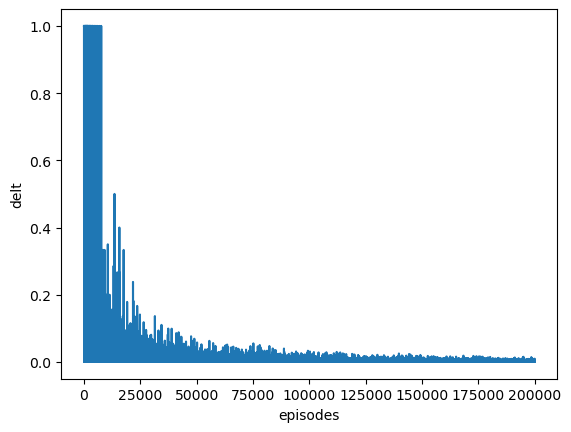

In [13]:
plt.plot(DELTA)
plt.xlabel("episodes")
plt.ylabel("delt")
plt.show()

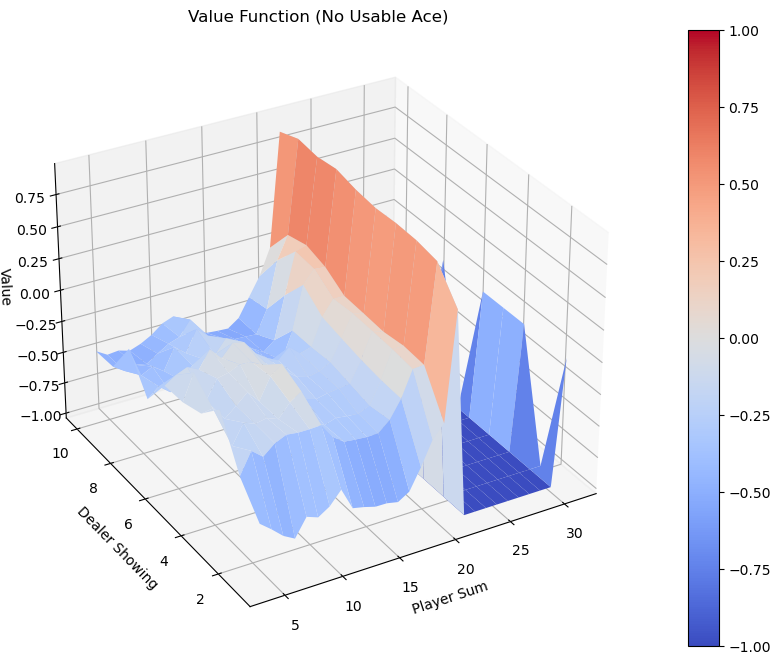

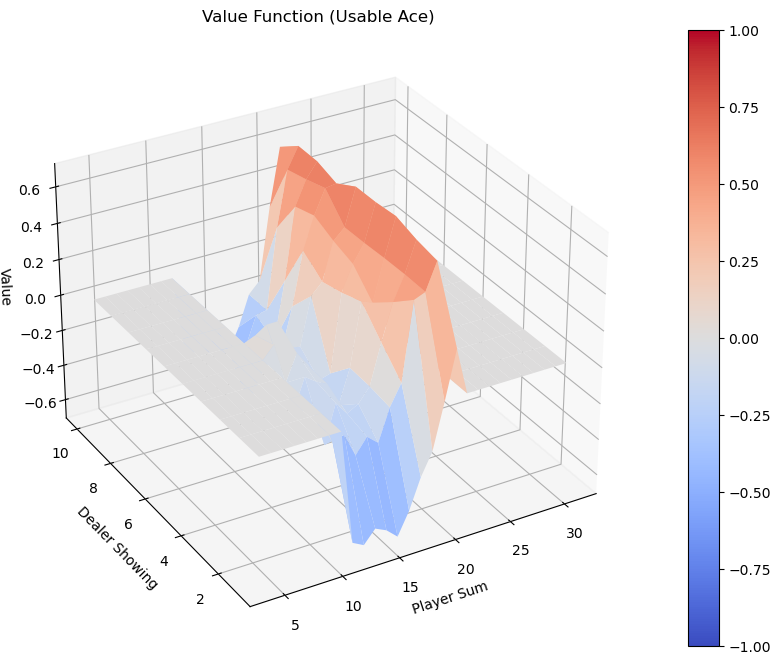

In [14]:
plot_value_function(V)

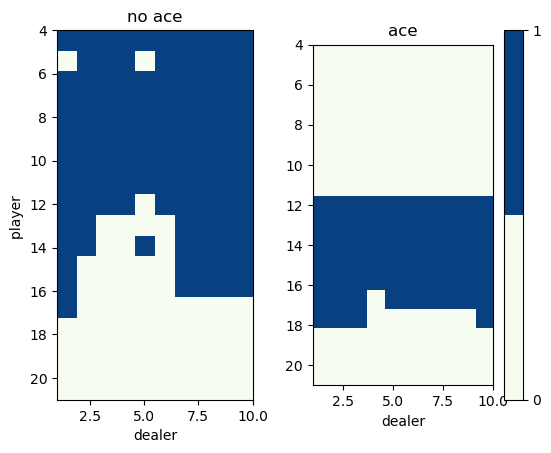

In [15]:
plot_policy_blackjack(policy)

In [16]:
games_with_policy(environment = environment, 
                  policy = policy, 
                  episodes = 100)

_________________________________________
Episode 0
State: (14, 9, True)
The Agent's current sum: 14, The Dealer's one showing card: 9, Agent's usable ace: True
The Agent has the following cards: [1, 3]
The Dealer has the following cards: [9, 10]
Hit
State: (15, 9, True)
The Agent's current sum: 15, The Dealer's one showing card: 9, Agent's usable ace: True
The Agent has the following cards: [1, 3, 1]
The Dealer has the following cards: [9, 10]
Hit
State: (12, 9, False)
The Agent's current sum: 12, The Dealer's one showing card: 9, Agent's usable ace: False
The Agent has the following cards: [1, 3, 1, 7]
The Dealer has the following cards: [9, 10]
Hit
State: (19, 9, False)
The Agent's current sum: 19, The Dealer's one showing card: 9, Agent's usable ace: False
The Agent has the following cards: [1, 3, 1, 7, 7]
The Dealer has the following cards: [9, 10]
Stand
State: (19, 9, False)
The Agent's current sum: 19, The Dealer's one showing card: 9, Agent's usable ace: False
The Agent has the

In [ ]:
accuracy = [] 
episodes = []

for n_episode in [1, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 2000000]:
#for n_episode in [100002000000]:
   
    print("n_episode: ", str(n_episode))
    policy, V, Q, DELTA = monte_carlo_on_policy(environment = environment, 
                                         N_episodes = n_episode, 
                                         discount_factor = 1, 
                                         first_visit = True, 
                                         theta = 0)  
    
    average ,std_win = average_wins(environment = environment, 
                                    policy = policy, 
                                    episodes = 5000000)
    
    print("n_episode: ", str(n_episode), " average: ", str(average))
    accuracy.append(average)
    episodes.append(n_episode)

In [ ]:
plt.plot(episodes, accuracy)
plt.title("Number of wins vs number of episodes ")
plt.ylabel('percentage of wins')
plt.xlabel('number of episodes ')
plt.show()

#### 4.2.2 Monte Carlo On-Policy Every Visit & Eploring Starts

In [ ]:
import itertools
import time

# Define the hyperparameter values to test
n_episode_values = [200000]
discount_factor_values = [0.7, 0.9, 0.95, 0.99, 1.0]
first_visit_values = [False]
epsilon_values = [0.05, 0.1, 0.2, 0.5, 0.9]
theta_values = [0]#, 0.001, 0.05, 0.1, 0.5, 1.0]

# Lists to store the results
tuning_results = []

# Perform grid search
for n_episode, discount_factor, first_visit, epsilon, theta in itertools.product(n_episode_values, discount_factor_values, first_visit_values, epsilon_values, theta_values):
    print(f"n_episode: {n_episode}, discount_factor: {discount_factor}, first_visit: {first_visit}, epsilon: {epsilon}, theta: {theta}")
    
    start_time = time.time()  # Record the start time

    policy, V, Q, DELTA = monte_carlo_on_policy(environment=environment, 
                                         N_episodes=n_episode, 
                                         discount_factor=discount_factor, 
                                         first_visit=first_visit, 
                                         epsilon=epsilon,
                                         theta=theta)
    
    elapsed_time = time.time() - start_time  # Calculate elapsed time


    average, std_win = average_wins(environment=environment, policy=policy, episodes=5000000)
    
    print(f"Average: {average}\n")
    print(f"Elapsed Time: {elapsed_time} seconds\n")  # Print the elapsed time
    
    tuning_results.append({
        "n_episode": n_episode,
        "discount_factor": discount_factor,
        "first_visit": first_visit,
        "epsilon": epsilon,
        "theta": theta,
        "average": average,
        "elapsed_time": elapsed_time
    })

# Find the best combination of hyperparameters
best_result = max(tuning_results, key=lambda x: x["average"])
print("Best Hyperparameters:")
print("n_episode:", best_result["n_episode"])
print("discount_factor:", best_result["discount_factor"])
print("first_visit:", best_result["first_visit"])
print("epsilon:", best_result["epsilon"])
print("theta:", best_result["theta"])
print("Average:", best_result["average"])
print("Elapsed Time:", best_result["elapsed_time"], "seconds")


In [17]:
policy, V, Q, DELTA = monte_carlo_on_policy(environment, N_episodes = 200000, discount_factor = 1, epsilon = 0.1, first_visit = False, theta=0)  

In [18]:
average, std_win = average_wins(environment, policy=policy, episodes=200000)
print("Average number of wins", average)

Average number of wins 0.43203


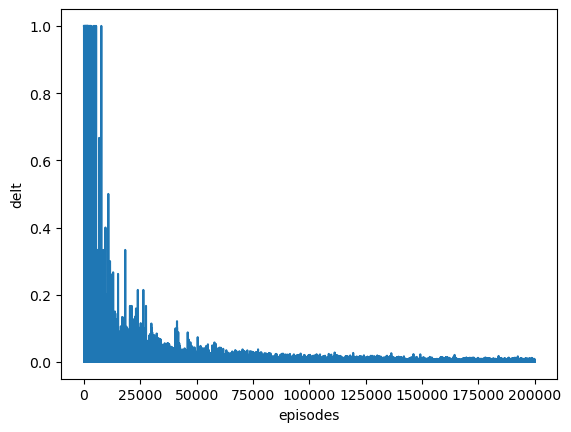

In [19]:
plt.plot(DELTA)
plt.xlabel("episodes")
plt.ylabel("delt")
plt.show()

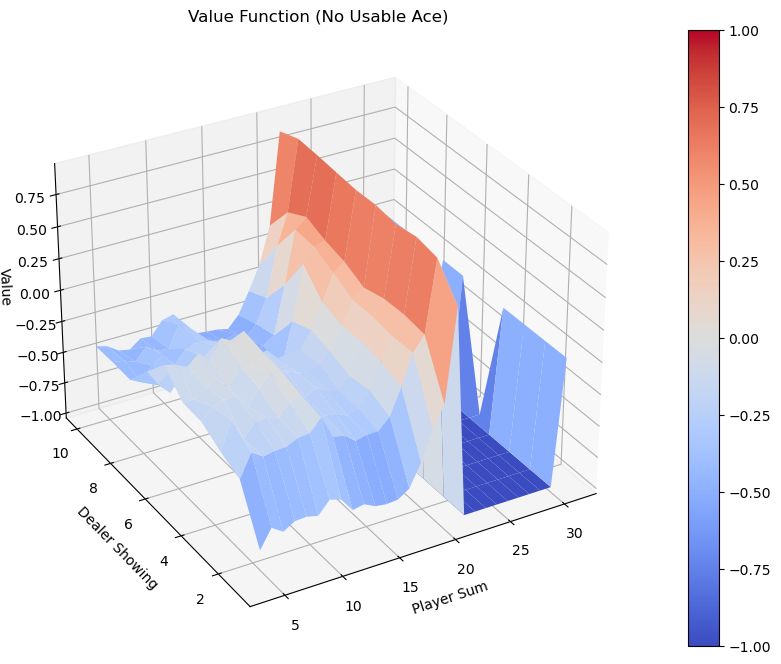

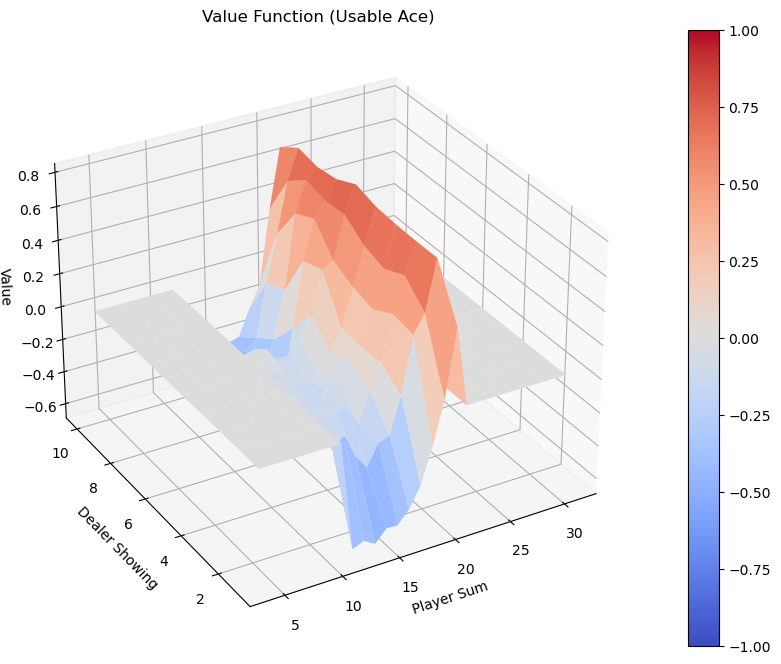

In [20]:
plot_value_function(V)

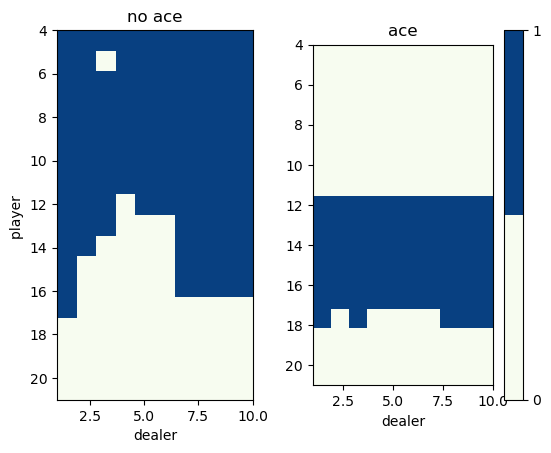

In [21]:
plot_policy_blackjack(policy)

In [22]:
games_with_policy(environment = environment, 
                  policy = policy, 
                  episodes = 100)

_________________________________________
Episode 0
State: (12, 10, False)
The Agent's current sum: 12, The Dealer's one showing card: 10, Agent's usable ace: False
The Agent has the following cards: [2, 10]
The Dealer has the following cards: [10, 9]
Hit
State: (22, 10, False)
The Agent's current sum: 22, The Dealer's one showing card: 10, Agent's usable ace: False
The Agent has the following cards: [2, 10, 10]
The Dealer has the following cards: [10, 9]
Done: True
state: (22, 10, False)
player has [2, 10, 10]
the players current sum:22,dealer's one showing card:10, usable ace:False
dealer cards: [10, 9] and score: 19 your score i: 22 
Bust
_________________________________________
Episode 1
State: (14, 9, True)
The Agent's current sum: 14, The Dealer's one showing card: 9, Agent's usable ace: True
The Agent has the following cards: [1, 3]
The Dealer has the following cards: [9, 2]
Hit
State: (20, 9, True)
The Agent's current sum: 20, The Dealer's one showing card: 9, Agent's usable a

In [ ]:
accuracy = [] 
episodes = []

for n_episode in [1, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 2000000]:
#for n_episode in [100002000000]:
   
    print("n_episode: ", str(n_episode))
    policy, Q, DELTA = monte_carlo_on_policy(environment = environment, 
                                         N_episodes = n_episode, 
                                         discount_factor = 1, 
                                         theta = 0)  
    
    average ,std_win = average_wins(environment = environment, 
                                    policy = policy, 
                                    episodes = 5000000)
    
    print("n_episode: ", str(n_episode), " average: ", str(average))
    accuracy.append(average)
    episodes.append(n_episode)

In [ ]:
plt.plot(episodes, accuracy)
plt.title("Number of wins vs number of episodes ")
plt.ylabel('percentage of wins')
plt.xlabel('number of episodes ')
plt.show()

#### 4.2.3 Monte Carlo Off-Policy 

In [ ]:
# Define the hyperparameter values to test
n_episode_values = [200000]
discount_factor_values = [0.7, 0.9, 0.95, 0.99, 1.0]
epsilon_values = [0.05, 0.1, 0.2, 0.5, 0.9]
theta_values = [0]#, 0.001, 0.05, 0.1, 0.5, 1.0]

# Lists to store the results
tuning_results = []

# Perform grid search
for n_episode, discount_factor, epsilon, theta in itertools.product(n_episode_values, discount_factor_values, epsilon_values, theta_values):
    print(f"n_episode: {n_episode}, discount_factor: {discount_factor}, epsilon: {epsilon}, theta: {theta}")
    
    start_time = time.time()  # Record the start time

    policy, Q, DELTA = monte_carlo_off_policy(environment, 
                                              N_episodes = n_episode_values, 
                                              discount_factor = discount_factor_values, 
                                              epsilon = epsilon_values, 
                                              theta=theta_values)  
    
    elapsed_time = time.time() - start_time  # Calculate elapsed time


    average, std_win = average_wins(environment=environment, policy=policy, episodes=5000000)
    
    print(f"Average: {average}\n")
    print(f"Elapsed Time: {elapsed_time} seconds\n")  # Print the elapsed time
    
    tuning_results.append({
        "n_episode": n_episode,
        "discount_factor": discount_factor,
        "first_visit": first_visit,
        "epsilon": epsilon,
        "theta": theta,
        "average": average,
        "elapsed_time": elapsed_time
    })

# Find the best combination of hyperparameters
best_result = max(tuning_results, key=lambda x: x["average"])
print("Best Hyperparameters:")
print("n_episode:", best_result["n_episode"])
print("discount_factor:", best_result["discount_factor"])
print("first_visit:", best_result["first_visit"])
print("epsilon:", best_result["epsilon"])
print("theta:", best_result["theta"])
print("Average:", best_result["average"])
print("Elapsed Time:", best_result["elapsed_time"], "seconds")

In [23]:
policy, Q, DELTA = monte_carlo_off_policy(environment, N_episodes = 200000, discount_factor = 1, epsilon = 0.1, theta=0)  

In [24]:
average, std_win = average_wins(environment, policy=policy, episodes=200000)
print("Average number of wins", average)

Average number of wins 0.43263


In [ ]:
accuracy = [] 
episodes = []

for n_episode in [1, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 2000000]:
#for n_episode in [100002000000]:
   
    print("n_episode: ", str(n_episode))
    policy, Q, DELTA = monte_carlo_off_policy(environment = environment, 
                                         N_episodes = n_episode, 
                                         discount_factor = 1, 
                                         theta = 0)  
    
    average ,std_win = average_wins(environment = environment, 
                                    policy = policy, 
                                    episodes = 5000000)
    
    print("n_episode: ", str(n_episode), " average: ", str(average))
    accuracy.append(average)
    episodes.append(n_episode)

In [ ]:
plt.plot(episodes, accuracy)
plt.title("Number of wins vs number of episodes ")
plt.ylabel('percentage of wins')
plt.xlabel('number of episodes ')
plt.show()

### 4.3 Q-Learning

#### 4.3.1 Q-Learning Aggressive

In [25]:
# hyperparameters
learning_rate = 0.0001
n_episodes = 20000000
start_epsilon = 0.5
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.05

QLearningAgent_Aggressive = QLearningAgent(environment = environment, 
                                           agent_type = "Agressivo",
                                           learning_rate = learning_rate, 
                                           initial_epsilon = start_epsilon, 
                                           epsilon_decay = epsilon_decay, 
                                           final_epsilon = final_epsilon)

In [26]:
env = gym.wrappers.RecordEpisodeStatistics(environment, deque_size = n_episodes)

QLearningAgent_Aggressive.train(env = env, n_episodes = n_episodes)

100%|██████████| 20000000/20000000 [45:55<00:00, 7257.00it/s] 


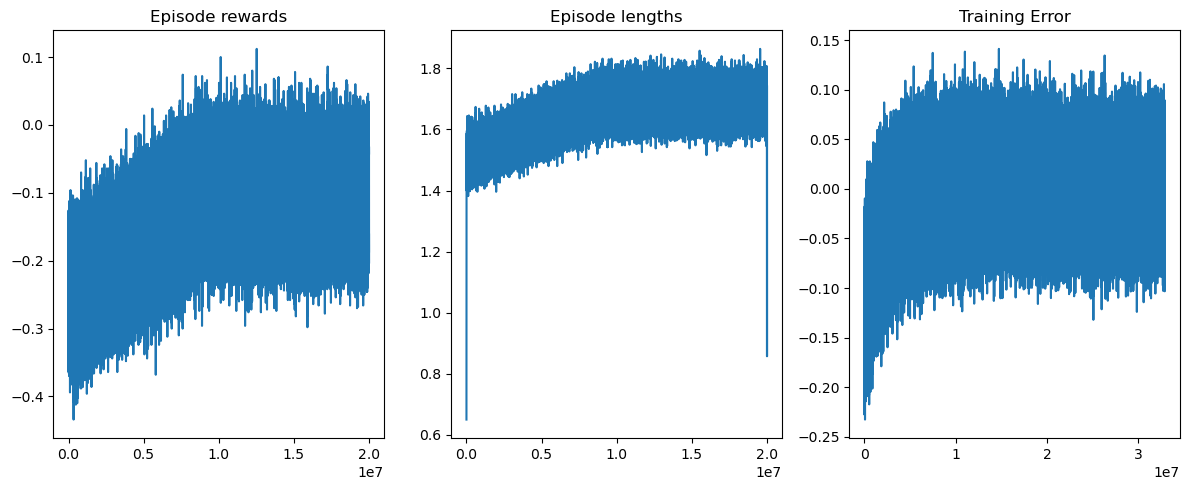

In [27]:
training_results(QLearningAgent_Aggressive, env)

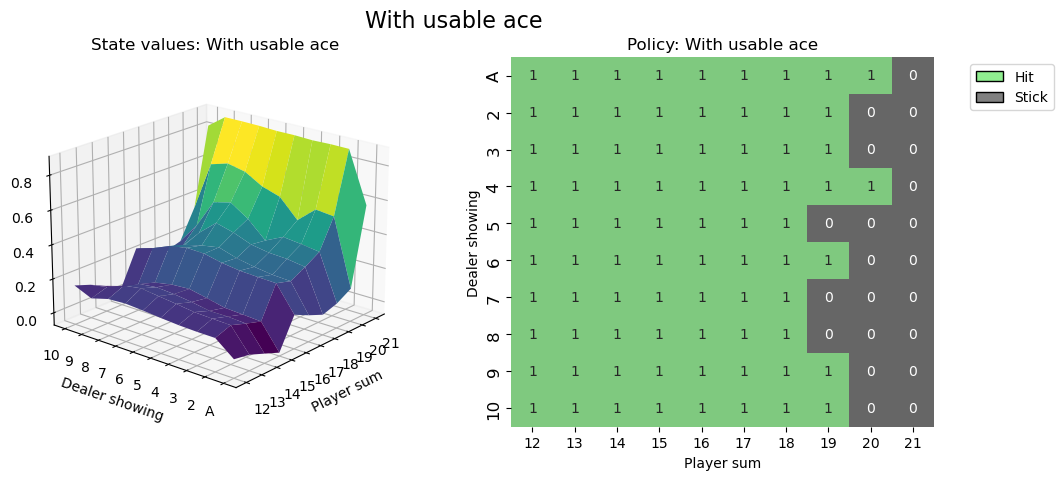

In [29]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(QLearningAgent_Aggressive, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

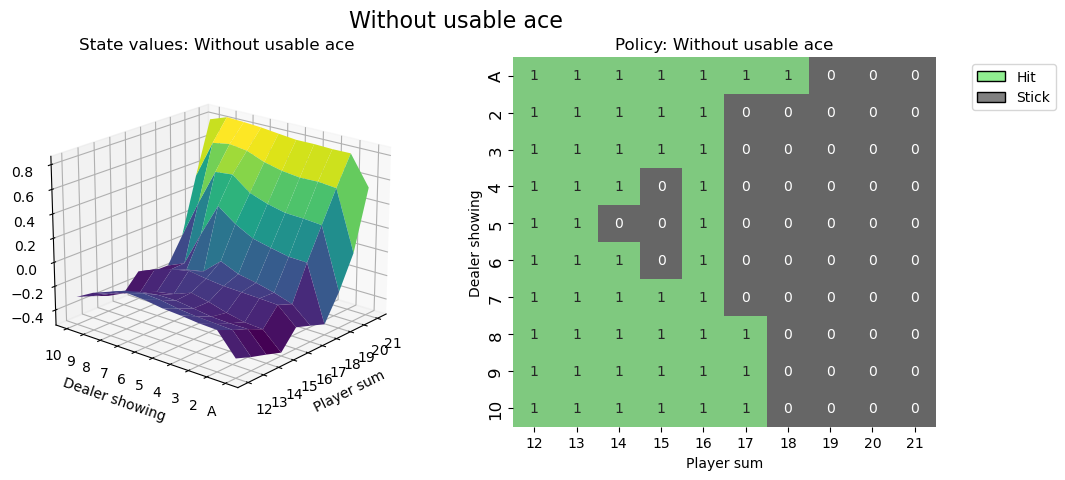

In [30]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(QLearningAgent_Aggressive, usable_ace=False)
fig1 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

#### 4.3.2 Q-Learning Conservative

In [31]:
# hyperparameters
learning_rate = 0.0001
n_episodes = 20000000
start_epsilon = 0.5
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.05

QLearningAgent_Conservative = QLearningAgent(environment = environment, 
                                             agent_type = "Conservador",
                                             learning_rate = learning_rate, 
                                             initial_epsilon = start_epsilon, 
                                             epsilon_decay = epsilon_decay, 
                                             final_epsilon = final_epsilon)

In [32]:
env = gym.wrappers.RecordEpisodeStatistics(environment, deque_size = n_episodes)

QLearningAgent_Conservative.train(env = env, n_episodes = n_episodes)

100%|██████████| 20000000/20000000 [51:55<00:00, 6419.04it/s]  


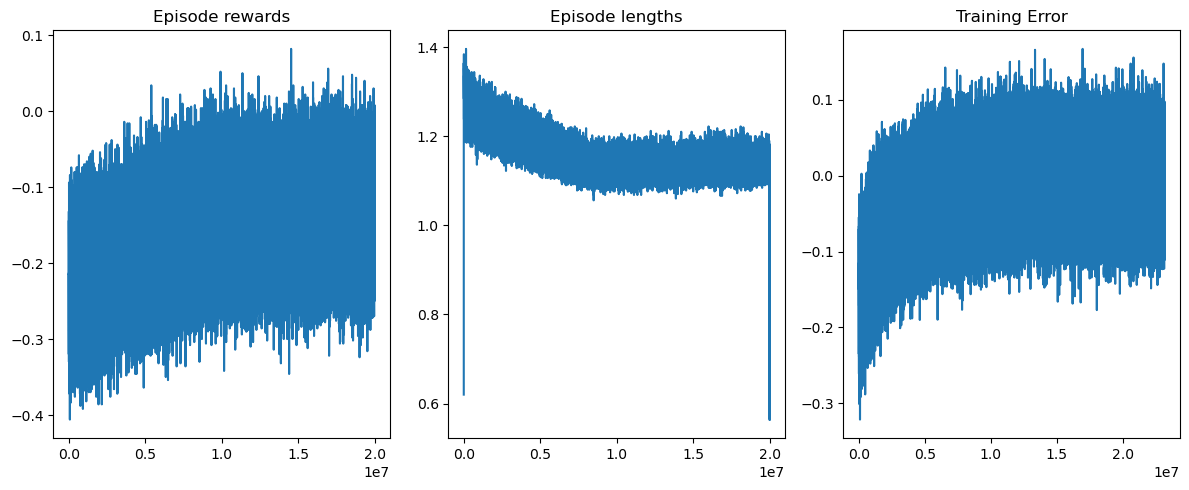

In [33]:
training_results(QLearningAgent_Conservative, env)

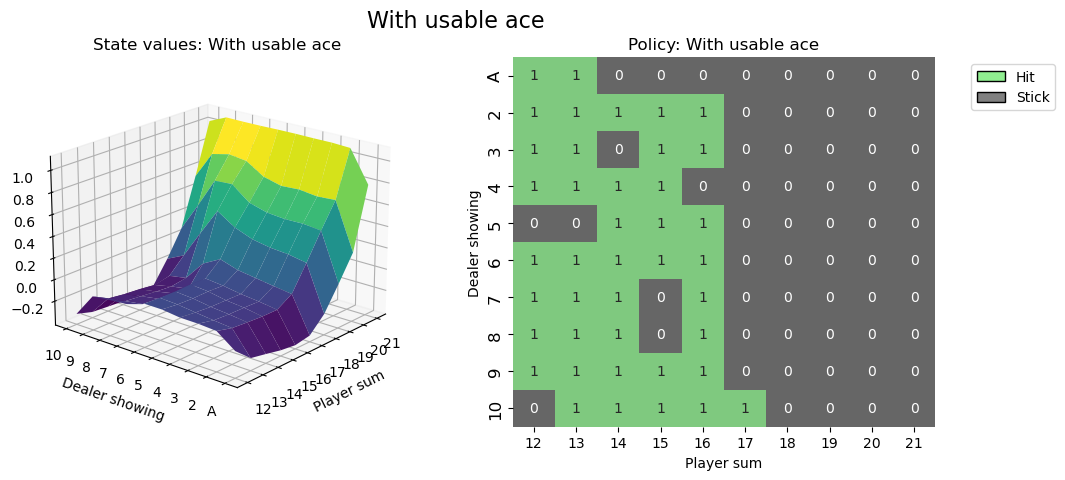

In [34]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(QLearningAgent_Conservative, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

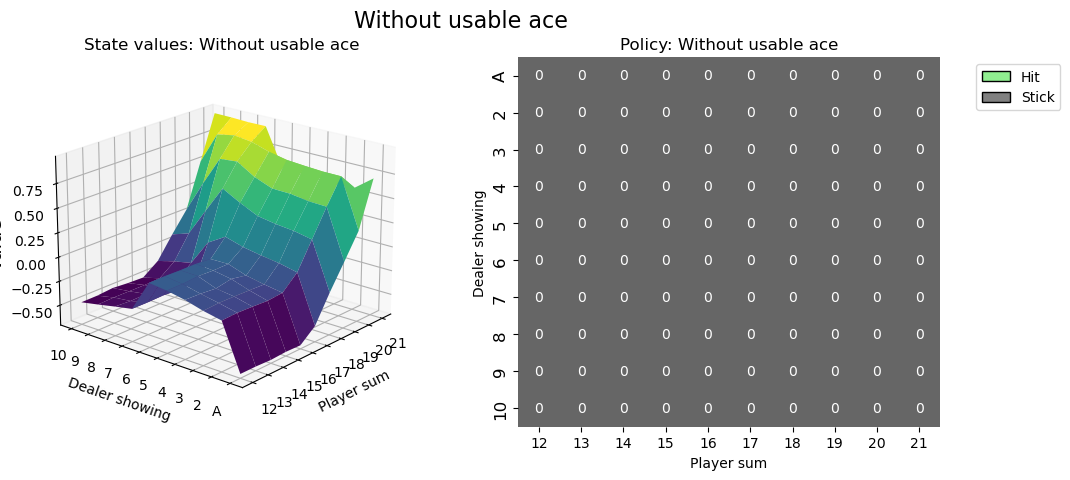

In [36]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(QLearningAgent_Conservative, usable_ace=False)
fig1 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

#### 4.3.3 Q-Learning Neutral

In [ ]:
# hyperparameters
learning_rate = 0.0001
n_episodes = 20000000
start_epsilon = 0.5
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.05

QLearningAgent_Neutral = QLearningAgent(environment = environment, 
                                             agent_type = "Neutro",
                                             learning_rate = learning_rate, 
                                             initial_epsilon = start_epsilon, 
                                             epsilon_decay = epsilon_decay, 
                                             final_epsilon = final_epsilon)

In [ ]:
env = gym.wrappers.RecordEpisodeStatistics(environment, deque_size = n_episodes)

QLearningAgent_Neutral.train(env = env, n_episodes = n_episodes)

In [ ]:
training_results(QLearningAgent_Conservative, env)

In [ ]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(QLearningAgent_Neutral, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

In [ ]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(QLearningAgent_Neutral, usable_ace=False)
fig1 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

### 4.4 Sarsa (Temporal Difference control)

#### 4.4.1 Sarsa Aggressive

In [ ]:
# hyperparameters
learning_rate = 0.0001
n_episodes = 20000000
start_epsilon = 0.5
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.05

SarsaAgent_Aggressive = SarsaAgent(environment = environment, 
                                   agent_type = "Agressivo",
                                   learning_rate = learning_rate, 
                                   initial_epsilon = start_epsilon, 
                                   epsilon_decay = epsilon_decay, 
                                   final_epsilon = final_epsilon)

In [ ]:
env = gym.wrappers.RecordEpisodeStatistics(environment, deque_size = n_episodes)

SarsaAgent_Aggressive.train(env = env, n_episodes = n_episodes)

In [35]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(SarsaAgent_Aggressive, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

NameError: name 'SarsaAgent_Aggressive' is not defined

In [ ]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(SarsaAgent_Aggressive, usable_ace=False)
fig1 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

In [ ]:
wins, draws, losses = play_n_games(SarsaAgent_Aggressive, environment, 5000000)
print("wins: {}, draws: {}, losses: {}".format(wins, draws, losses))

#### 4.4.2 Sarsa Conservative

In [ ]:
# hyperparameters
learning_rate = 0.0001
n_episodes = 20000000
start_epsilon = 0.5
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.05

SarsaAgent_Conservative = SarsaAgent(environment = environment, 
                                   agent_type = "Conservador",
                                   learning_rate = learning_rate, 
                                   initial_epsilon = start_epsilon, 
                                   epsilon_decay = epsilon_decay, 
                                   final_epsilon = final_epsilon)

In [ ]:
env = gym.wrappers.RecordEpisodeStatistics(environment, deque_size = n_episodes)

SarsaAgent_Conservative.train(env = env, n_episodes = n_episodes)

In [ ]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(SarsaAgent_Conservative, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

In [ ]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(SarsaAgent_Conservative, usable_ace=False)
fig1 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

In [ ]:
wins, draws, losses = play_n_games(SarsaAgent_Conservative, environment, 5000000)
print("wins: {}, draws: {}, losses: {}".format(wins, draws, losses))

#### 4.4.3 Sarsa Neutral

In [ ]:
# hyperparameters
learning_rate = 0.0001
n_episodes = 20000000
start_epsilon = 0.5
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.05

SarsaAgent_Neutral = SarsaAgent(environment = environment, 
                                   agent_type = "Neutral",
                                   learning_rate = learning_rate, 
                                   initial_epsilon = start_epsilon, 
                                   epsilon_decay = epsilon_decay, 
                                   final_epsilon = final_epsilon)

In [ ]:
env = gym.wrappers.RecordEpisodeStatistics(environment, deque_size = n_episodes)

SarsaAgent_Neutral.train(env = env, n_episodes = n_episodes)

In [ ]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(SarsaAgent_Neutral, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

In [ ]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(SarsaAgent_Neutral, usable_ace=False)
fig1 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

In [ ]:
wins, draws, losses = play_n_games(SarsaAgent_Neutral, environment, 5000000)
print("wins: {}, draws: {}, losses: {}".format(wins, draws, losses))

### 4.5 Deep Q-Learning (PyTorch)

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

In [7]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = environment.action_space.n
# Get the number of state observations
state = environment.reset()
n_observations = len(state)
# Set the device
device = set_device()

policy_net = DeepQLearningAgent(n_observations, n_actions).to(device)
target_net = DeepQLearningAgent(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.Adam(policy_net.parameters(), lr = LR, amsgrad = True)
memory = ReplayMemory(10000)

steps_done = 0

Device: cpu


In [8]:
train(environment, policy_network = policy_net, target_network = target_net, memory = memory, optimizer = optimizer, device = device, num_episodes = 10000000, TAU = TAU)

TypeError: select_action() missing 2 required positional arguments: 'policy_network' and 'device'